In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, \
  preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [2]:
!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip

--2023-10-21 05:44:55--  https://lazyprogrammer.me/course_files/Food-5K.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M  37.7MB/s    in 10s     

2023-10-21 05:45:06 (40.8 MB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



In [3]:
!unzip -qq -o Food-5K.zip

In [4]:
!ls

Food-5K  Food-5K.zip  __MACOSX	sample_data


In [6]:
!mv Food-5K/* .
!ls training

mv: cannot stat 'Food-5K/*': No such file or directory
0_0.jpg     0_1338.jpg	0_325.jpg  0_663.jpg  1_0.jpg	  1_1338.jpg  1_325.jpg  1_663.jpg
0_1000.jpg  0_1339.jpg	0_326.jpg  0_664.jpg  1_1000.jpg  1_1339.jpg  1_326.jpg  1_664.jpg
0_1001.jpg  0_133.jpg	0_327.jpg  0_665.jpg  1_1001.jpg  1_133.jpg   1_327.jpg  1_665.jpg
0_1002.jpg  0_1340.jpg	0_328.jpg  0_666.jpg  1_1002.jpg  1_1340.jpg  1_328.jpg  1_666.jpg
0_1003.jpg  0_1341.jpg	0_329.jpg  0_667.jpg  1_1003.jpg  1_1341.jpg  1_329.jpg  1_667.jpg
0_1004.jpg  0_1342.jpg	0_32.jpg   0_668.jpg  1_1004.jpg  1_1342.jpg  1_32.jpg	 1_668.jpg
0_1005.jpg  0_1343.jpg	0_330.jpg  0_669.jpg  1_1005.jpg  1_1343.jpg  1_330.jpg  1_669.jpg
0_1006.jpg  0_1344.jpg	0_331.jpg  0_66.jpg   1_1006.jpg  1_1344.jpg  1_331.jpg  1_66.jpg
0_1007.jpg  0_1345.jpg	0_332.jpg  0_670.jpg  1_1007.jpg  1_1345.jpg  1_332.jpg  1_670.jpg
0_1008.jpg  0_1346.jpg	0_333.jpg  0_671.jpg  1_1008.jpg  1_1346.jpg  1_333.jpg  1_671.jpg
0_1009.jpg  0_1347.jpg	0_334.jpg  0_672.jpg  1_100

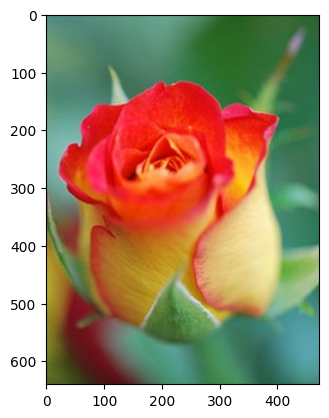

In [7]:
plt.imshow(image.load_img('training/0_808.jpg'))
plt.show()

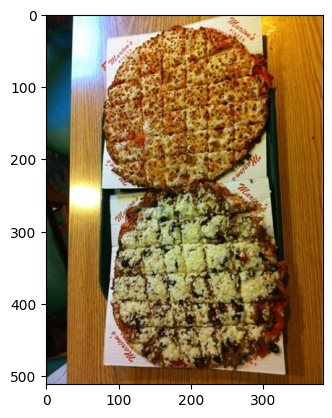

In [8]:
plt.imshow(image.load_img('training/1_616.jpg'))
plt.show()

In [9]:
!mkdir data

In [10]:
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

In [11]:
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

In [12]:
train_path = 'data/train'
valid_path = 'data/test'

In [13]:
# These images are pretty big and of different sizes
# Let's load them all in as the same (smaller) size
IMAGE_SIZE = [200, 200]

In [14]:
image_files = glob(train_path + '/*/*.jpg')
valid_image_files = glob(valid_path + '/*/*.jpg')

In [15]:
folders = glob(train_path + '/*')
folders

['data/train/food', 'data/train/nonfood']

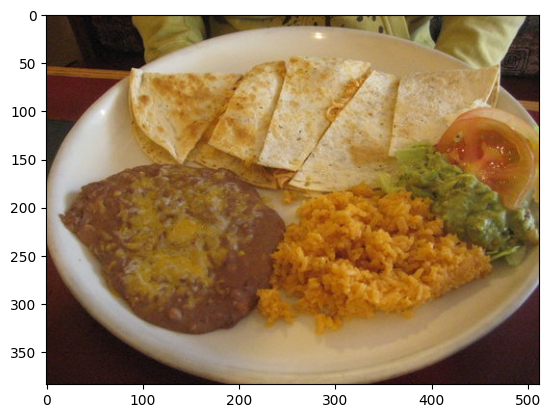

In [16]:
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

In [17]:
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [18]:
# map the data into feature vectors
x = Flatten()(ptm.output)

In [19]:
# create a model object
model = Model(inputs=ptm.input, outputs=x)

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [21]:
# create an instance of ImageDataGenerator
gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [22]:
batch_size = 128

# create generators
train_generator = gen.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
  class_mode='binary',
)

valid_generator = gen.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  batch_size=batch_size,
  class_mode='binary',
)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [23]:
Ntrain = len(image_files)
Nvalid = len(valid_image_files)

# Figure out the output size
feat = model.predict(np.random.random([1] + IMAGE_SIZE + [3]))
D = feat.shape[1]

X_train = np.zeros((Ntrain, D))
Y_train = np.zeros(Ntrain)
X_valid = np.zeros((Nvalid, D))
Y_valid = np.zeros(Nvalid)

1/1 [==============================] - 1s 746ms/step


In [24]:
# populate X_train and Y_train
i = 0
for x, y in train_generator:
  # get features
  features = model.predict(x)

  # size of the batch (may not always be batch_size)
  sz = len(y)

  # assign to X_train and Ytrain
  X_train[i:i + sz] = features
  Y_train[i:i + sz] = y

  # increment i
  i += sz
  print(i)

  if i >= Ntrain:
    print('breaking now')
    break
print(i)

4/4 [==============================] - 64s 16s/step
128
4/4 [==============================] - 59s 15s/step
256
4/4 [==============================] - 60s 15s/step
384
4/4 [==============================] - 58s 14s/step
512
4/4 [==============================] - 59s 15s/step
640
4/4 [==============================] - 58s 14s/step
768
4/4 [==============================] - 56s 14s/step
896
4/4 [==============================] - 56s 14s/step
1024
4/4 [==============================] - 60s 15s/step
1152
4/4 [==============================] - 56s 14s/step
1280
4/4 [==============================] - 56s 14s/step
1408
4/4 [==============================] - 56s 14s/step
1536
4/4 [==============================] - 56s 14s/step
1664
4/4 [==============================] - 56s 14s/step
1792
4/4 [==============================] - 56s 14s/step
1920
4/4 [==============================] - 56s 14s/step
2048
4/4 [==============================] - 56s 14s/step
2176
4/4 [==============================] -

In [ ]:
# populate X_valid and Y_valid
i = 0
for x, y in valid_generator:
  # get features
  features = model.predict(x)

  # size of the batch (may not always be batch_size)
  sz = len(y)

  # assign to X_train and Ytrain
  X_valid[i:i + sz] = features
  Y_valid[i:i + sz] = y

  # increment i
  i += sz

  if i >= Nvalid:
    print('breaking now')
    break
print(i)

4/4 [==============================] - 47s 11s/step


In [ ]:
X_train.max(), X_train.min()

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train2 = scaler.fit_transform(X_train)
X_valid2 = scaler.transform(X_valid)

In [28]:
## Do logistic regression in Tensorflow

i = Input(shape=(D,))
x = Dense(1, activation='sigmoid')(i)
linearmodel = Model(i, x)

In [29]:
linearmodel.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [30]:
# Can try both normalized and unnormalized data
r = linearmodel.fit(
    X_train, Y_train,
    batch_size=128,
    epochs=10,
    validation_data=(X_valid, Y_valid),
)

Epoch 1/10
24/24 [==============================] - 1s 24ms/step - loss: 1.1404 - accuracy: 0.9263 - val_loss: 0.4060 - val_accuracy: 0.9730
Epoch 2/10
24/24 [==============================] - 0s 9ms/step - loss: 0.1060 - accuracy: 0.9910 - val_loss: 0.4541 - val_accuracy: 0.9710
Epoch 3/10
24/24 [==============================] - 0s 9ms/step - loss: 0.0065 - accuracy: 0.9983 - val_loss: 0.3664 - val_accuracy: 0.9760
Epoch 4/10
24/24 [==============================] - 0s 9ms/step - loss: 1.6093e-04 - accuracy: 1.0000 - val_loss: 0.3813 - val_accuracy: 0.9760
Epoch 5/10
24/24 [==============================] - 0s 10ms/step - loss: 1.9289e-05 - accuracy: 1.0000 - val_loss: 0.3920 - val_accuracy: 0.9750
Epoch 6/10
24/24 [==============================] - 0s 10ms/step - loss: 1.1250e-05 - accuracy: 1.0000 - val_loss: 0.3915 - val_accuracy: 0.9750
Epoch 7/10
24/24 [==============================] - 0s 10ms/step - loss: 7.8235e-06 - accuracy: 1.0000 - val_loss: 0.3902 - val_accuracy: 0.9750


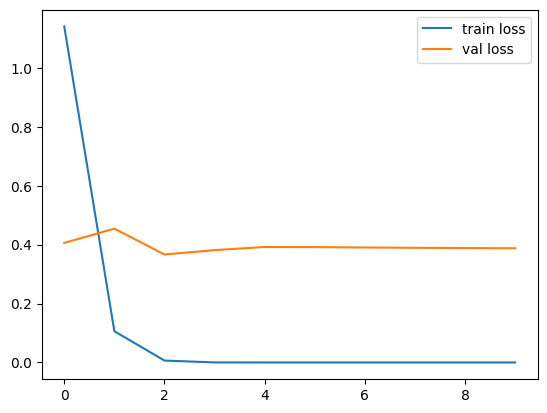

In [31]:
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

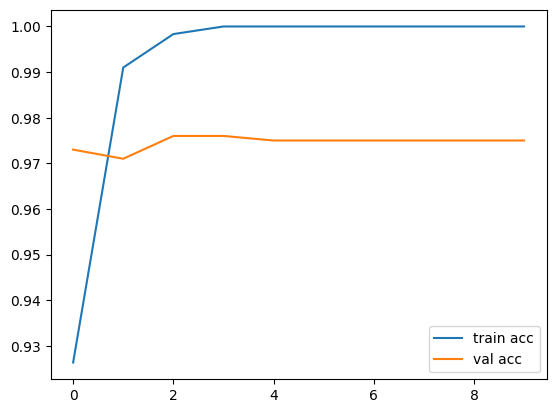

In [32]:
# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()